# 1.Unsupervised Lab

**Objective:** 
   - Use K-Means for this analysis
   - Cluster the students to see if there are some natural groupings
   - Use PCA to plot the clusters
   - Discover any insights from this analysis? (include numbers/graphs corresponding to your reasoning)

**Things to keep in mind:**
* EDA!!!  Explore your data!
* Does the dataset have missing values?
* What about categorical vs numeric columns in your dataset?
* Do you think you should normalize your data?

## 1.A Python Setup

In [1]:
import logging
import math
import matplotlib.cm
import matplotlib.pyplot
import msds_utils
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.compose
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import sklearn.pipeline
%matplotlib inline


pd.set_option('max_row', 100)

# Set up logging ... INFO or DEBUG for my code, WARNING for libraries
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

LOGGER = logging.getLogger('Week6')


## 1.B Data Acquisition

### 1.B.1 Examine the data file

In [2]:
# Examine the file type
!file data/assign_wk6/student-mat.csv
!wc -l data/assign_wk6/student-mat.csv
!head -n 3 data/assign_wk6/student-mat.csv

data/assign_wk6/student-mat.csv: ASCII text
396 data/assign_wk6/student-mat.csv
school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3
"GP";"F";18;"U";"GT3";"A";4;4;"at_home";"teacher";"course";"mother";2;2;0;"yes";"no";"no";"no";"yes";"yes";"no";"no";4;3;4;1;1;3;6;"5";"6";6
"GP";"F";17;"U";"GT3";"T";1;1;"at_home";"other";"course";"father";1;2;0;"no";"yes";"no";"no";"no";"yes";"yes";"no";5;3;3;1;1;3;4;"5";"5";6


### 1.B.2 Load the file and verify

In [3]:
# Load the file (separator is ';' vice ',')
student_df = pd.read_csv('data/assign_wk6/student-mat.csv', sep=';')

# Verify the loaded file (based on 'wc -l' above, we expect 395 lines)
df_rows, df_cols = student_df.shape
LOGGER.info(f'student_df.shape ==> ({df_rows}, {df_cols})')
student_df.head()

2021-11-26 05:07:28 - INFO   -      Week6 - student_df.shape ==> (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### 1.B.3 Examine columns

In [4]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## 1.C EDA

### 1.C.1 Individual features

In [5]:
# Convert categorical yes/no to 1/0
# (other, more complex categories, will be handled by one-hot
# encoding, but that's not necessary for binary conditions)
student_df.replace(to_replace='yes', value=1, inplace=True)
student_df.replace(to_replace='no', value=0, inplace=True)

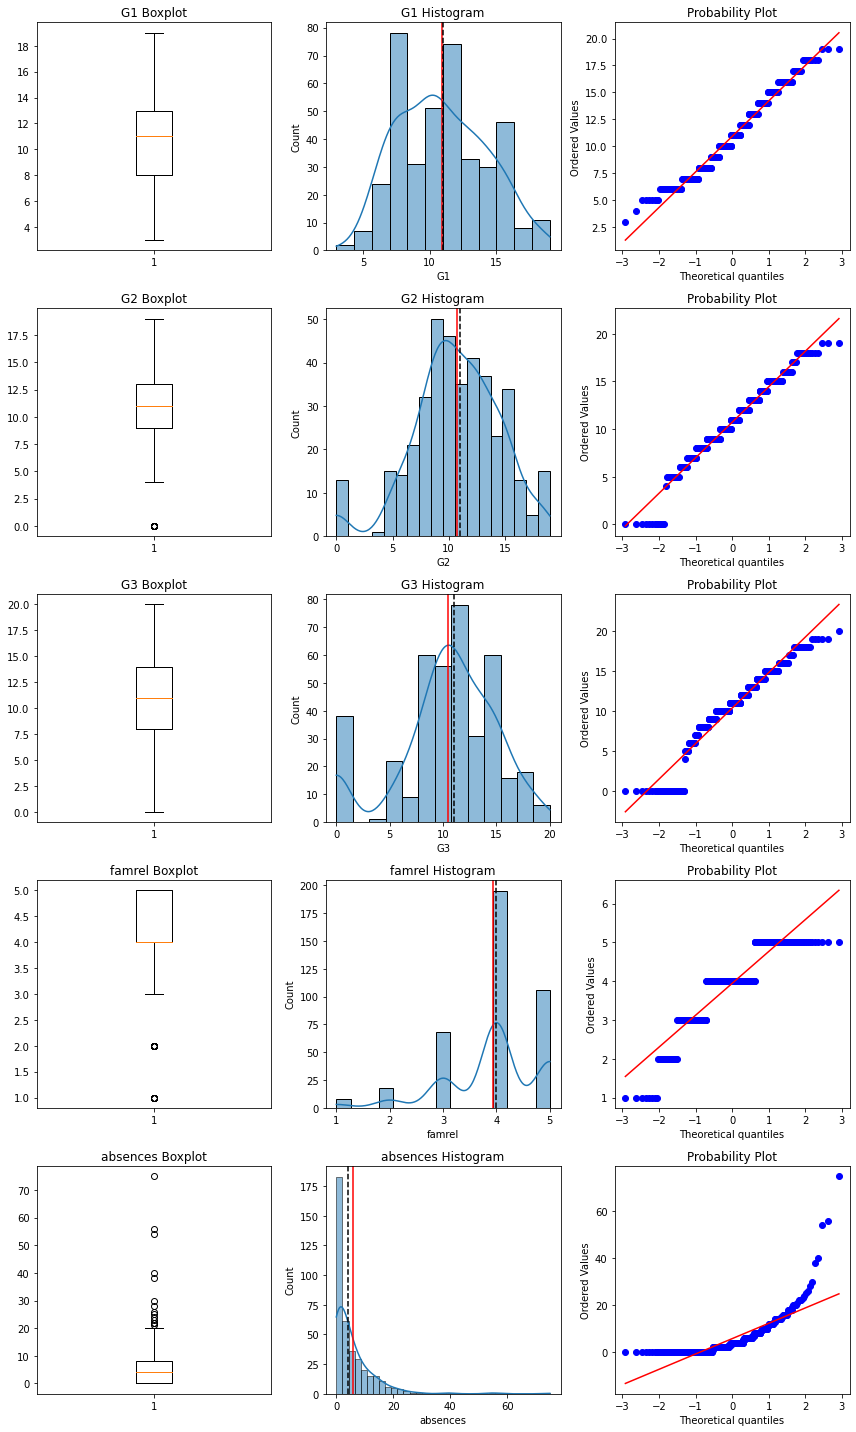

In [6]:
# Let's examine a subset of inputs to begin characterizing the data:
msds_utils.summary_graphs(student_df, ['G1', 'G2', 'G3', 'famrel', 'absences'])

### 1.C.2 Feature relationships

<AxesSubplot:>

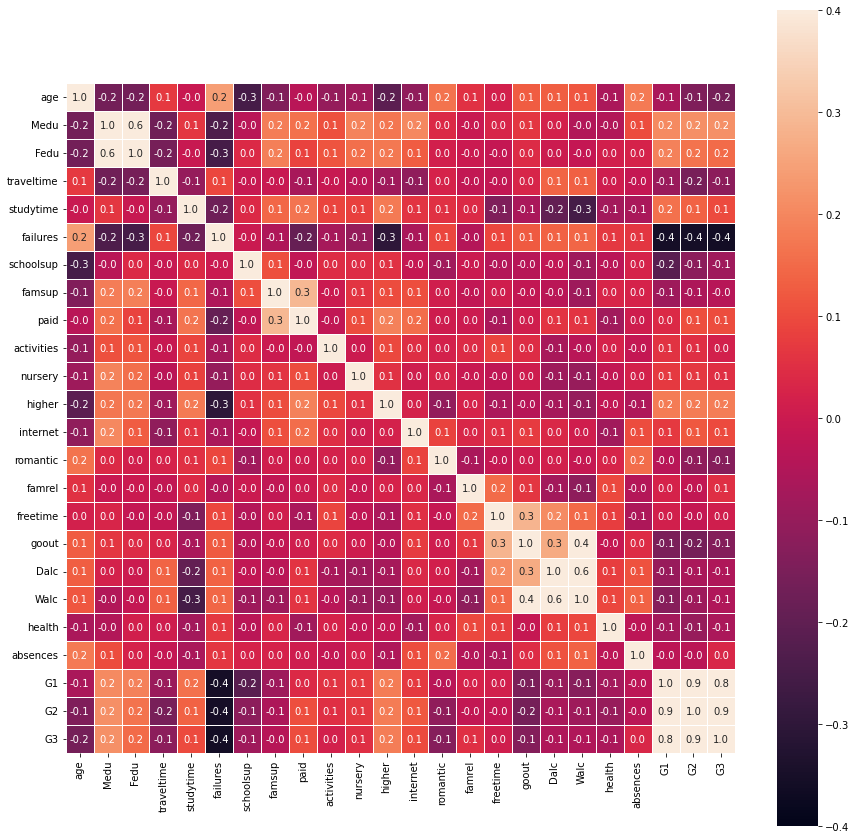

In [7]:
# Let's see if there are any correlation hints from a heatmap:
matplotlib.pyplot.figure(figsize=(15, 15))
sns.heatmap(student_df.corr(), vmin=-0.4, vmax=0.4, fmt='.1f', linewidths=0.7, square=True, annot=True)

### 1.C.2 Feature relationships (cont'd)

Some things like previous **`failures`** are negatively correlated (`-0.4`) to **`G1-G3`**.  Other things like mother's and father's education (**`Medu`** and **`Fedu`**, respectively), along with a student desire for higher education (**`higher`**), appear to be slightly positively correlated (`0.2`) to **`G1-G3`**.

# 2 K-Means clustering

## 2.A Values for `k`

The following block collects various metrics for **`k`** values between from `2` to `20`.

In [8]:
MIN_K=2
MAX_K=20
NUMERICAL = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CATEGORICAL = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']
random_state = 42

# Here, we create a Pipeline with only transformations, no estimator
#
# This allows us to fit and transform the data automatically AND have
# access to the transformed data afterwards
xforms = sklearn.pipeline.Pipeline([
    (f'ColumnTransformer', sklearn.compose.ColumnTransformer(transformers=[

        # We want to apply StandardScaler only to numerical columns:
        (f'StandardScaler',
            sklearn.preprocessing.StandardScaler(), [student_df.columns.tolist().index(x) for x in NUMERICAL]),

        # One-hot encode categorical columns:
        (f'OneHot-Encoder', sklearn.preprocessing.OneHotEncoder(), [student_df.columns.tolist().index(x) for x in CATEGORICAL])

    ], remainder='passthrough')),
])

# Here, we fit and transform the data and save it off as 'X' (this becomes
# the set of inputs for subsequent K-Means models and PCA analysis)
X = xforms.fit_transform(student_df)

# Arrays of metrics to be collected for each value of k
sum_squares = []
silhouettes = []
inertia = []
silhouette_plot_values = []

for k in range(MIN_K, MAX_K + 1):
    model = sklearn.cluster.KMeans(n_clusters=k, random_state=random_state, n_init=20)

    LOGGER.debug(f'Performking K-Means with {k} clusters')
    predictions_k = model.fit_predict(X)
    sum_squares_k = abs(model.score(X))
    silhouette_k = sklearn.metrics.silhouette_score(X, predictions_k)

    sum_squares.append(sum_squares_k)
    silhouettes.append(silhouette_k)
    inertia.append(model.inertia_)
    
    silhouette_plot_values.append({
        'k': k,
        'silhouette_mean': silhouette_k,
        'predictions': predictions_k,
        'silhouette_values': sklearn.metrics.silhouette_samples(X, predictions_k)
    })

    LOGGER.info(f'With k={k: >02d} and utilizing all features, mean silhouette score: {silhouette_k:4.2}')



2021-11-26 05:07:34 - INFO   -      Week6 - With k= 2 and utilizing all features, mean silhouette score: 0.11
2021-11-26 05:07:34 - INFO   -      Week6 - With k= 3 and utilizing all features, mean silhouette score: 0.086
2021-11-26 05:07:34 - INFO   -      Week6 - With k= 4 and utilizing all features, mean silhouette score: 0.073
2021-11-26 05:07:35 - INFO   -      Week6 - With k= 5 and utilizing all features, mean silhouette score: 0.066
2021-11-26 05:07:35 - INFO   -      Week6 - With k= 6 and utilizing all features, mean silhouette score: 0.065
2021-11-26 05:07:36 - INFO   -      Week6 - With k= 7 and utilizing all features, mean silhouette score: 0.057
2021-11-26 05:07:36 - INFO   -      Week6 - With k= 8 and utilizing all features, mean silhouette score: 0.061
2021-11-26 05:07:37 - INFO   -      Week6 - With k= 9 and utilizing all features, mean silhouette score: 0.057
2021-11-26 05:07:37 - INFO   -      Week6 - With k=10 and utilizing all features, mean silhouette score: 0.055
20

## 2.B Analysis: sum of squares (elbow method)

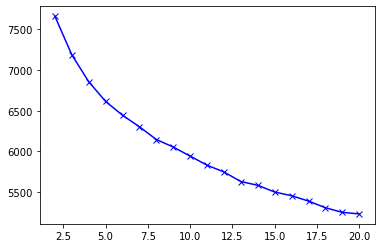

In [9]:
_ = matplotlib.pyplot.plot(range(MIN_K, MAX_K + 1), sum_squares, 'bx-')


**Conclusion: sum of squares**: No obvious elbow to select `k`

## 2.C Analysis: sum of squares differences (elbow method)

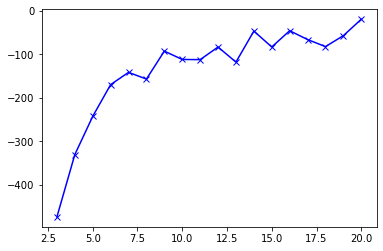

In [10]:
_ = matplotlib.pyplot.plot(range(MIN_K + 1, MAX_K + 1), np.diff(sum_squares), 'bx-')


**Conclusion: sum of squares differences**: No obvious elbow to select `k`

## 2.D Analysis of inertia

K-Means model inertia measures the sum of the squared distances to the nearest cluster center (Dmitry, 2019)

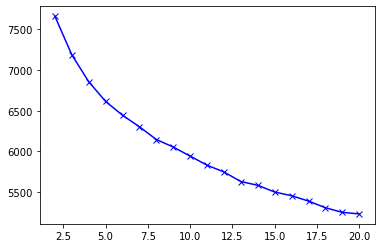

In [11]:
_ = matplotlib.pyplot.plot(range(MIN_K, MAX_K + 1), inertia, 'bx-')


**Conclusion: inertia**: No obvious elbow to select `k`

## 2.E Analysis of silhouette score

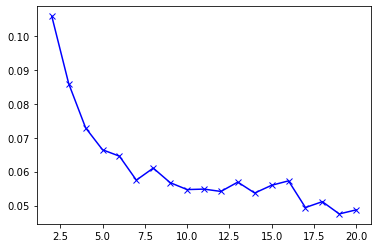

In [12]:
_ = matplotlib.pyplot.plot(range(MIN_K, MAX_K + 1), silhouettes, 'bx-')


**Conclusion: silhouette score**: For silhouette score, we are actually looking for the peak value (vice an elbow).  The peak silhouette score for clustering this data set appears to be approximately two clusters.

## 2.F Closer look at silhouette scores

According to Scikit-Learn.org (n.d.), the best value for silhouette score is 1 (the worst value is -1). Overlapping clusters are indicated by values near 0. *Negative values generally indicate that a sample has been assigned to the wrong cluster (e.g., a different cluster is more similar)*.

The following *silhouette plots* show individual sample silhouette scores (vice the mean of the data set) for various values of `k`.  For higher values of `k`, many samples are assigned to incorrect clusters (negative silhouette score).  Although the plot for `k=2` also shows mis-assigned samples, we can see why `k=2` scored best.

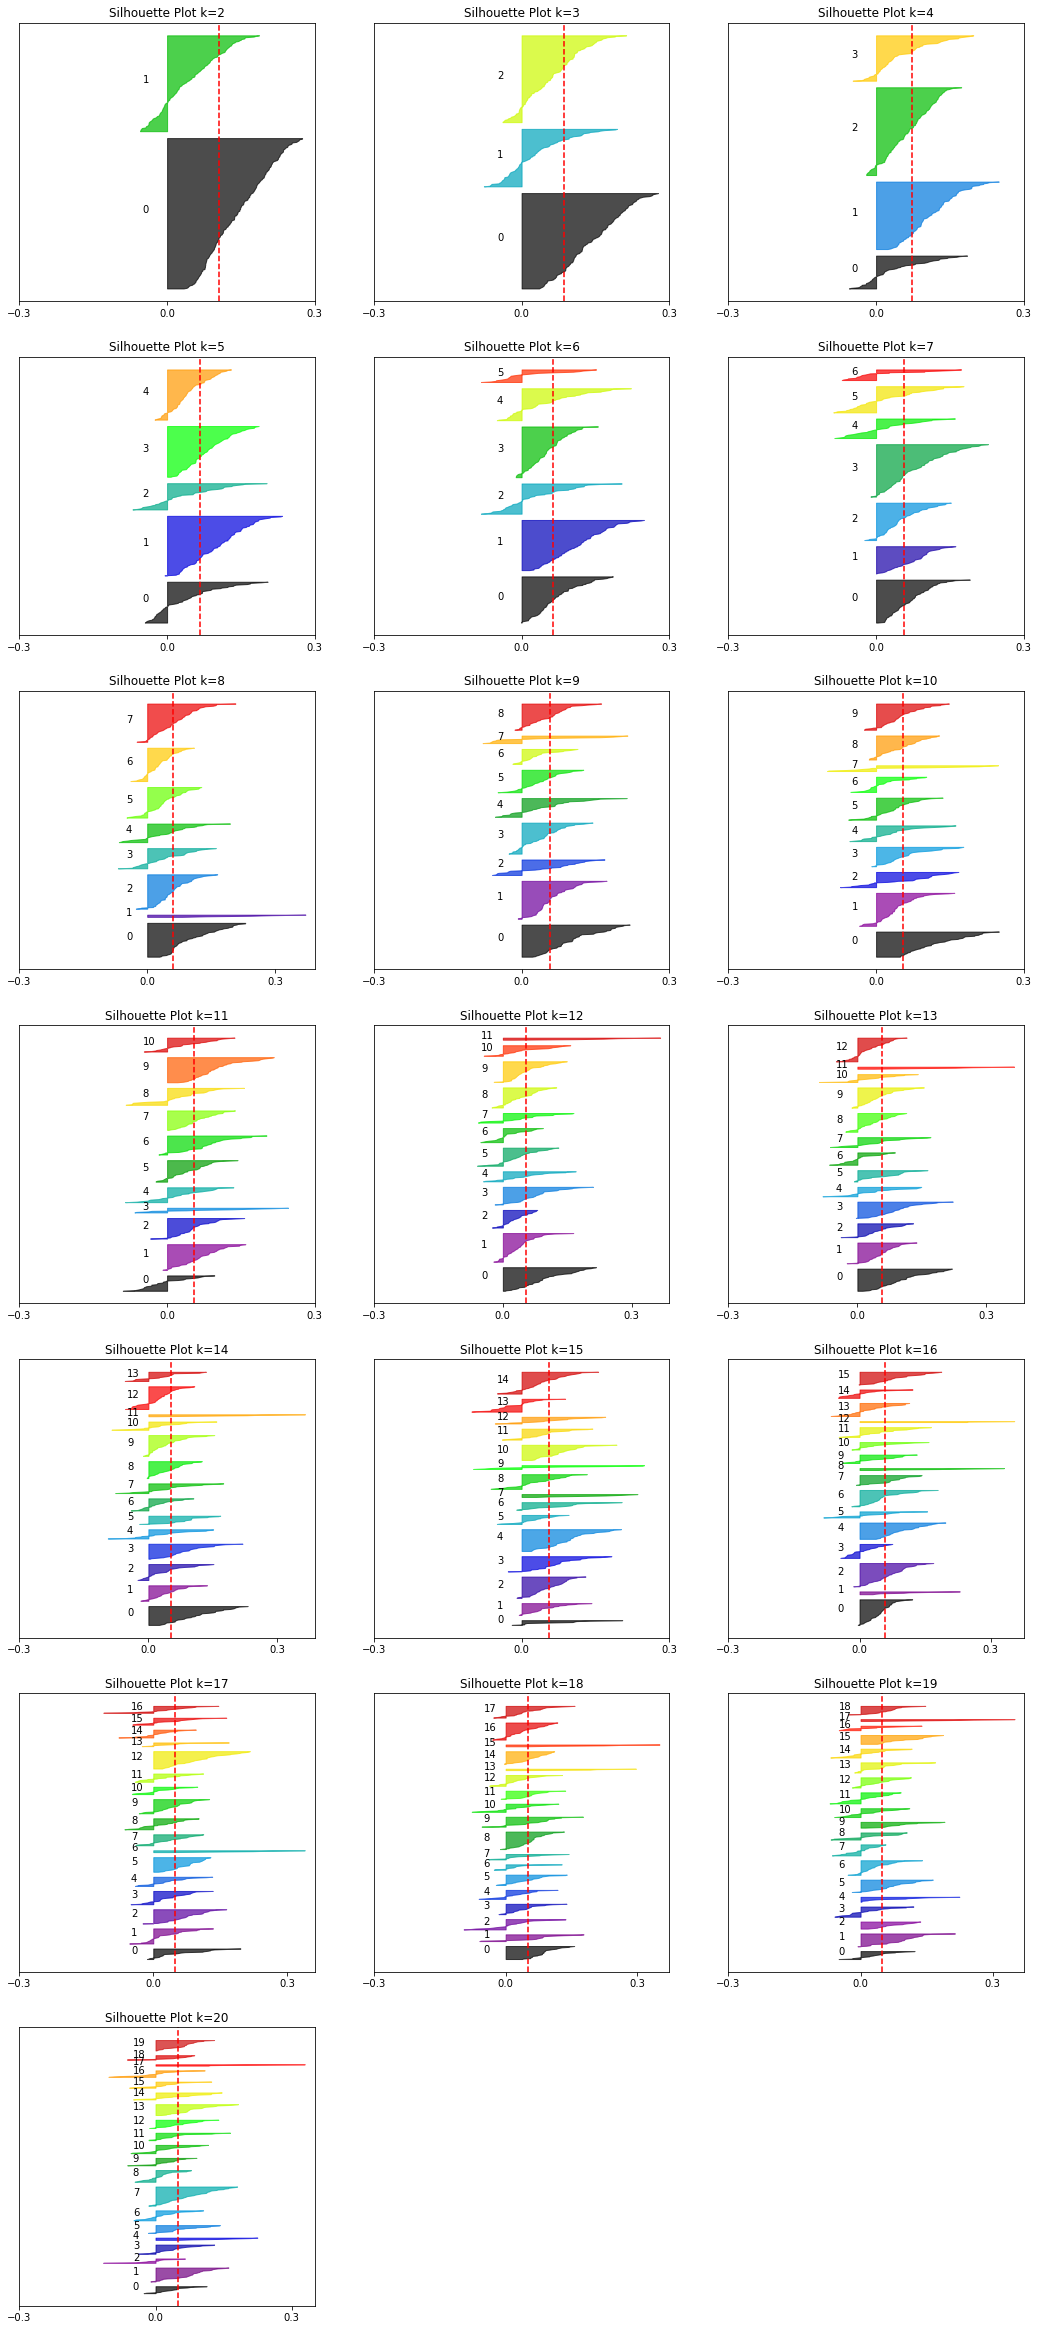

In [13]:
BEST_K=2
msds_utils.silhouette_graphs(silhouette_plot_values, figure_cols=3, size=6.0)


# 3 Principal Component Analysis (PCA)

## 3.A PCA component optimization

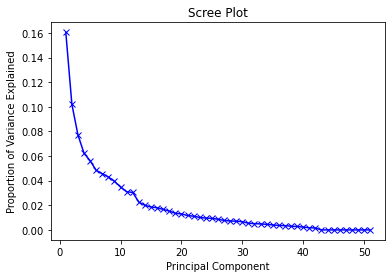

In [14]:
# Create a Principal Component with all Features so we can compare numerous PCs
# (the PCA constructore argument 'n_components' defaults to None,
# which is exactly what we want)
pca = sklearn.decomposition.PCA()

pca_X = pca.fit_transform(X)

pca_df = pd.DataFrame(pca_X)

pc_values = np.arange(pca.n_components_) + 1
matplotlib.pyplot.plot(pc_values, pca.explained_variance_ratio_, 'bx-')
matplotlib.pyplot.title('Scree Plot')
matplotlib.pyplot.xlabel('Principal Component')
matplotlib.pyplot.ylabel('Proportion of Variance Explained')
matplotlib.pyplot.show()

In [15]:
# Check the variance explained by various combinations of principal components
for i in [1, 2, 4, 5, 11, 12, 13]:
    variance_explained = np.sum(pca.explained_variance_ratio_[:i])
    LOGGER.info(f'The first {i: >2d} principal components account for {variance_explained:6.2%} of the variance')

BEST_PC = 13

2021-11-26 05:07:46 - INFO   -      Week6 - The first  1 principal components account for 16.05% of the variance
2021-11-26 05:07:46 - INFO   -      Week6 - The first  2 principal components account for 26.25% of the variance
2021-11-26 05:07:46 - INFO   -      Week6 - The first  4 principal components account for 40.17% of the variance
2021-11-26 05:07:46 - INFO   -      Week6 - The first  5 principal components account for 45.79% of the variance
2021-11-26 05:07:46 - INFO   -      Week6 - The first 11 principal components account for 70.01% of the variance
2021-11-26 05:07:46 - INFO   -      Week6 - The first 12 principal components account for 73.05% of the variance
2021-11-26 05:07:46 - INFO   -      Week6 - The first 13 principal components account for 75.31% of the variance


**Conclusion: PCA components**: In this case, there is an elbow in the PCA component graph, although it's not necessarily obvious which quantity of principal components to choose.  Based on the calculation above, we can use `13` principal components and account for `75%` of the variance of the data set.  One could also argue for selecting `4` - `5` principal components.

## 3.B Verify selected K with optimized PCA

Let's see if `k=2` is still best, given a PCA-transformed view of the data

In [16]:
# Create a new PCA utilizing the selected quantity of components
best_components_pca = sklearn.decomposition.PCA(n_components=BEST_PC)

# Transform the data set to the PCA coordinate system
best_pca_X = best_components_pca.fit_transform(X)

max_silhouette = -999.99

for k in range(MIN_K, MAX_K + 1):
    model = sklearn.cluster.KMeans(n_clusters=k, random_state=random_state, n_init=20)

    LOGGER.debug(f'Performking K-Means with {k} clusters')
    predictions_k = model.fit_predict(best_pca_X)
    sum_squares_k = abs(model.score(best_pca_X))
    silhouette_k = sklearn.metrics.silhouette_score(best_pca_X, predictions_k)

    if silhouette_k > max_silhouette:
        max_silhouette = silhouette_k
        LOGGER.info(f'With k={k: >2d} and utilizing {BEST_PC} features, mean silhouette score: {silhouette_k:6.2f}')


2021-11-26 05:07:47 - INFO   -      Week6 - With k= 2 and utilizing 13 features, mean silhouette score:   0.14


## 3.C Optimized K with optimized PCA

This is somewhat repetitive with the above code block, but this time we're saving our values using meaninful variable names (in the above code block, we iterated thru a series of values and didn't save the best results)

2021-11-26 05:07:52 - INFO   -      Week6 - With k=2 and utilizing 13 PCA components, mean silhouette score:   0.14


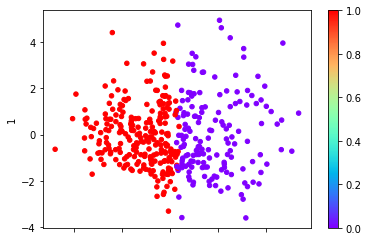

In [17]:
# Create a new PCA utilizing the selected quantity of components
best_components_pca = sklearn.decomposition.PCA(n_components=BEST_PC)

# Transform the data set to the PCA coordinate system
best_pca_X = best_components_pca.fit_transform(X)

# Create a new KMeans clustering model utilizing the selected best k value:
best_kmeans_model = sklearn.cluster.KMeans(n_clusters=BEST_K, random_state=random_state, n_init=20)

# Fit the model, then get each sample's assigned cluster (via prediction)
best_kmeans_predictions = best_kmeans_model.fit_predict(best_pca_X)

# We expect a better silhouette score than the K-Means run against the unreduced data
best_kmeans_silhouette_score = sklearn.metrics.silhouette_score(best_pca_X, best_kmeans_predictions)

LOGGER.info(f'With k={BEST_K} and utilizing {BEST_PC} PCA components, mean silhouette score: {best_kmeans_silhouette_score:6.2f}')

# Plot the data in PCA coordinates and color by cluster
best_pca_data_df = pd.DataFrame(best_pca_X)
_ = best_pca_data_df.plot(kind='scatter', x=0, y=1, c=best_kmeans_predictions, cmap='rainbow')

# 4 What does it mean?

## 4.A Principal components vs Features

### 4.A.1 Combinations of Features can be mappped to combinations of principal components

Below, we create a DataFrame that contains each Feature's contribution to each principal component

In [18]:
pc_list = [ f'PC{i}' for i in list(range(1, pca.n_features_ + 1)) ]
mapped_pc = dict(zip(pc_list, pca.components_))
components_df = pd.DataFrame.from_dict(mapped_pc)
components_df['Feature'] = xforms.get_feature_names_out()
components_df = components_df.set_index('Feature')
components_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51
Feature,,,,,,,,,,,,,,,,,,,,,
StandardScaler__age,0.171219,0.057268,-0.241211,0.319393,0.461696,0.160864,0.187762,-0.107829,-0.426171,-0.220623,...,-0.061074,9.134669e-17,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
StandardScaler__Medu,-0.242345,0.201468,0.509603,0.129204,0.046072,0.034692,0.144561,-0.148439,-0.115771,0.104611,...,-0.043586,9.370780e-17,1.353084e-16,2.220446e-16,-5.846451e-18,6.332834e-17,9.575069e-17,-1.356599e-16,-2.775558e-17,-2.428613e-17
StandardScaler__Fedu,-0.216876,0.182488,0.519503,0.074548,-0.051958,0.064566,0.206753,-0.149801,-0.247433,-0.092323,...,0.034901,3.397124e-17,-7.271084e-17,-6.874691e-18,8.011964e-18,4.292353e-17,4.652287e-17,8.040732e-17,-9.549004e-18,-6.776966e-17
StandardScaler__traveltime,0.152399,0.042138,-0.239442,0.014205,-0.278572,-0.216531,0.694828,-0.274711,0.056164,0.335328,...,-0.006242,6.451126e-17,-2.140179e-16,1.357025e-16,6.694429e-18,9.008553e-17,-2.626850e-17,-9.107235e-17,9.503914e-17,8.177147e-18
StandardScaler__studytime,-0.154931,-0.239486,0.020440,0.134467,0.322850,-0.383918,0.184559,0.556585,-0.165492,0.247735,...,0.024238,-1.398468e-20,2.132714e-17,7.278154e-18,-1.114199e-16,8.201327e-17,1.954854e-17,7.114307e-17,-1.742560e-17,-5.507998e-18


### 4.A.2 Heat map of Feature-to-PC contribution

Now we can visualize each Feature's contribution to each principal component in a heat map

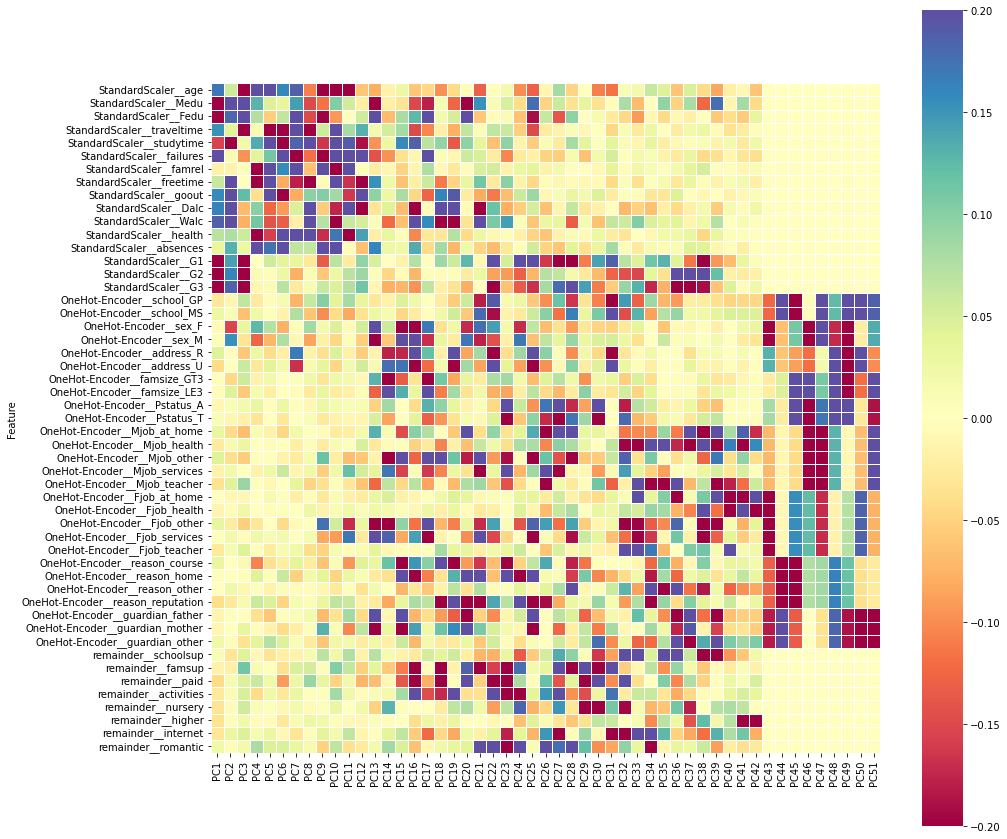

In [19]:
matplotlib.pyplot.figure(figsize=(15, 15))
_ = sns.heatmap(components_df, vmin=-0.2, vmax=0.2, fmt='.1f', linewidths=0.7, square=True, cmap='Spectral')

The heat map above shows several highly correlated features (both positively and negatively) for principal components `1` - `13`-ish (it becomes less clear for higher dimension principal components).

For example, it seems that the following Features have the greatest impact on PC `1`:

| Feature                       | Correlation   |
|:------------------------------|:--------------|
| StandardScaler__age           | Positive      |
| StandardScaler__Medu          | Negative      |
| StandardScaler__Fedu          | Negative      |
| StandardScaler__traveltime    | Positive      |
| StandardScaler__studytime     | Negative      |
| StandardScaler__failures      | Positive      |
| StandardScaler__Walc          | Positive      |
| StandardScaler__G1            | Negative      |
| StandardScaler__G2            | Negative      |
| StandardScaler__G3            | Negative      |

**NOTE**: The positive/negative correlation is with respect to the PC `1` axis and
          does not imply postive/negative outcome.  In fact, it seems that the
          outcome is the inverse.

## 4.B Relate clusters back to original students

Below, we create a new dataframe and demonstrate the ability to identify each student's cluster

In [20]:
student_clustered_df = pd.DataFrame(student_df)
student_clustered_df['best_pca_cluster'] = best_kmeans_predictions
student_clustered_df.head()[['school', 'sex', 'age', 'Medu', 'Fedu', 'traveltime', 'G1', 'G2', 'G3', 'best_pca_cluster']]

,school,sex,age,Medu,Fedu,traveltime,G1,G2,G3,best_pca_cluster
0,GP,F,18,4,4,2,5,6,6,0
1,GP,F,17,1,1,1,5,5,6,0
2,GP,F,15,1,1,1,7,8,10,0
3,GP,F,15,4,2,1,15,14,15,1
4,GP,F,16,3,3,1,6,10,10,1


# 5 Bonus analysis

Up until this point, I felt like I had a pretty good explanation for each observation contained above.  However, I made the "*mistake*" of continuing to play with the PCA analysis and found that utilizing lower dimensions yields much better silhouette scores.

This seems similar to this week's reading (*6_Unsupervised_Machine_Learning*) in which the initial choice of `k=10` performed worse than `k=2` (utilizing silhouette score as the metric).

Below, I demonstrate what I found.

## 5.A Compare silhouette scores for various numbers of principal components

In [21]:
for i in range(1, BEST_PC):
    # Create a new PCA utilizing a different number of components, for comparison
    comparison_pca = sklearn.decomposition.PCA(n_components=i)

    # Transform the data set to the PCA coordinate system
    comparison_pca_X = comparison_pca.fit_transform(X)

    # Re-create a new KMeans clustering model utilizing the selected best k value:
    comparison_kmeans_model = sklearn.cluster.KMeans(n_clusters=BEST_K, random_state=random_state, n_init=20)

    # Fit the model using the comparison data, then get each sample's assigned cluster (via prediction)
    comparison_kmeans_predictions = comparison_kmeans_model.fit_predict(comparison_pca_X)

    comparison_kmeans_silhouette_score = sklearn.metrics.silhouette_score(comparison_pca_X, comparison_kmeans_predictions)
    LOGGER.info(f'With k={BEST_K} and utilizing {i: >2d} PCA components, mean silhouette score: {comparison_kmeans_silhouette_score:4.2f}')


2021-11-26 05:07:54 - INFO   -      Week6 - With k=2 and utilizing  1 PCA components, mean silhouette score: 0.55
2021-11-26 05:07:54 - INFO   -      Week6 - With k=2 and utilizing  2 PCA components, mean silhouette score: 0.36
2021-11-26 05:07:54 - INFO   -      Week6 - With k=2 and utilizing  3 PCA components, mean silhouette score: 0.28
2021-11-26 05:07:55 - INFO   -      Week6 - With k=2 and utilizing  4 PCA components, mean silhouette score: 0.24
2021-11-26 05:07:55 - INFO   -      Week6 - With k=2 and utilizing  5 PCA components, mean silhouette score: 0.21
2021-11-26 05:07:55 - INFO   -      Week6 - With k=2 and utilizing  6 PCA components, mean silhouette score: 0.20
2021-11-26 05:07:55 - INFO   -      Week6 - With k=2 and utilizing  7 PCA components, mean silhouette score: 0.18
2021-11-26 05:07:55 - INFO   -      Week6 - With k=2 and utilizing  8 PCA components, mean silhouette score: 0.17
2021-11-26 05:07:56 - INFO   -      Week6 - With k=2 and utilizing  9 PCA components, me

## 5.B K-Means with 1 principal component

**NOTE**: A single component means we are using one dimension, which is basically a number line.

2021-11-26 05:07:57 - INFO   -      Week6 - With k=2 and utilizing 1 PCA component, mean silhouette score:   0.55


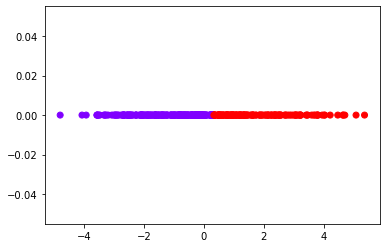

In [22]:
# Create a new PCA utilizing a different number of components, for comparison
comparison1_pca = sklearn.decomposition.PCA(n_components=1)

# Transform the data set to the PCA coordinate system
comparison1_pca_X = comparison1_pca.fit_transform(X)

# Re-create a new KMeans clustering model utilizing the selected best k value:
comparison1_kmeans_model = sklearn.cluster.KMeans(n_clusters=BEST_K, random_state=random_state, n_init=20)

# Fit the model using the comparison data, then get each sample's assigned cluster (via prediction)
comparison1_kmeans_predictions = comparison1_kmeans_model.fit_predict(comparison1_pca_X)

comparison1_kmeans_silhouette_score = sklearn.metrics.silhouette_score(comparison1_pca_X, comparison1_kmeans_predictions)
LOGGER.info(f'With k={BEST_K} and utilizing 1 PCA component, mean silhouette score: {comparison1_kmeans_silhouette_score:6.2}')

y_axis = np.zeros(comparison1_pca_X.shape)
y_axis.shape

_ = matplotlib.pyplot.scatter(comparison1_pca_X, y_axis, c=comparison1_kmeans_predictions, cmap='rainbow')


## 5.C K-Means with 2 principal components


2021-11-26 05:07:57 - INFO   -      Week6 - With k=2 and utilizing 2 PCA components, mean silhouette score:   0.36


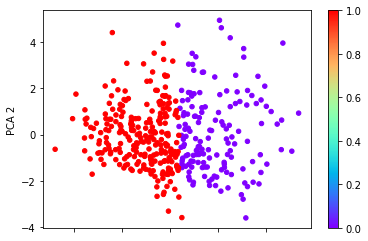

In [23]:
# Create a new PCA utilizing a different number of components, for comparison
comparison2_pca = sklearn.decomposition.PCA(n_components=2)

# Transform the data set to the PCA coordinate system
comparison2_pca_X = comparison2_pca.fit_transform(X)

# Re-create a new KMeans clustering model utilizing the selected best k value:
comparison2_kmeans_model = sklearn.cluster.KMeans(n_clusters=BEST_K, random_state=random_state, n_init=20)

# Fit the model using the comparison data, then get each sample's assigned cluster (via prediction)
comparison2_kmeans_predictions = comparison2_kmeans_model.fit_predict(comparison2_pca_X)

comparison2_kmeans_silhouette_score = sklearn.metrics.silhouette_score(comparison2_pca_X, comparison2_kmeans_predictions)
LOGGER.info(f'With k={BEST_K} and utilizing 2 PCA components, mean silhouette score: {comparison2_kmeans_silhouette_score:6.2f}')

# Plot the data in PCA coordinates and color by cluster
comparison2_pca_df = pd.DataFrame(comparison2_pca_X)
comparison2_pca_df.plot(kind='scatter', x=0, y=1, c=comparison2_kmeans_predictions, cmap='rainbow')
_ = matplotlib.pyplot.xlabel('PCA 1')
_ = matplotlib.pyplot.ylabel('PCA 2')


## 5.D Compare clustering results

Using the scatter plots above, it's not obvious which samples are being re-assigned to different clusters based on different PCA results.

### 5.D.1 Compare original clusters to 1 principal components

Below, we add the `PC=1` cluster assignments to the dataframe so that we can compare the `k=2`, `PC=13` (original clustering) to `k=2`, `PC=1` cluster assignments.

In [24]:
student_clustered_df['comparison1_pca_cluster'] = comparison1_kmeans_predictions

cluster_diff1_df = student_clustered_df[student_clustered_df['best_pca_cluster'].ne(student_clustered_df['comparison1_pca_cluster'])]
cluster_diff1_df[['best_pca_cluster', 'comparison1_pca_cluster']]

,best_pca_cluster,comparison1_pca_cluster
0,0,1
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
390,0,1
391,1,0
392,0,1
393,0,1


We could consider this to be a drastic re-clustering, or the clusters bacsically inverted (389 rows changed)!!

### 5.D.2 Compare original clusters to 2 principal components

Below, we add the `PC=2` cluster assignments to the dataframe so that we can compare the `k=2`, `PC=13` (original clustering) to `k=2`, `PC=2`

In [25]:
student_clustered_df['comparison2_pca_cluster'] = comparison2_kmeans_predictions

cluster_diff2_df = student_clustered_df[student_clustered_df['best_pca_cluster'].ne(student_clustered_df['comparison2_pca_cluster'])]
cluster_diff2_df[['best_pca_cluster', 'comparison2_pca_cluster']]

,best_pca_cluster,comparison2_pca_cluster
62,0,1
95,0,1
132,0,1
138,1,0
180,0,1
201,0,1
209,0,1
210,0,1
259,0,1
339,0,1


In this case, we had ~10 samples switch from one cluster to another.

### 5.D.3 Compare silhouette plots

Finally, we compare the silhouette sample values for the three values of PC

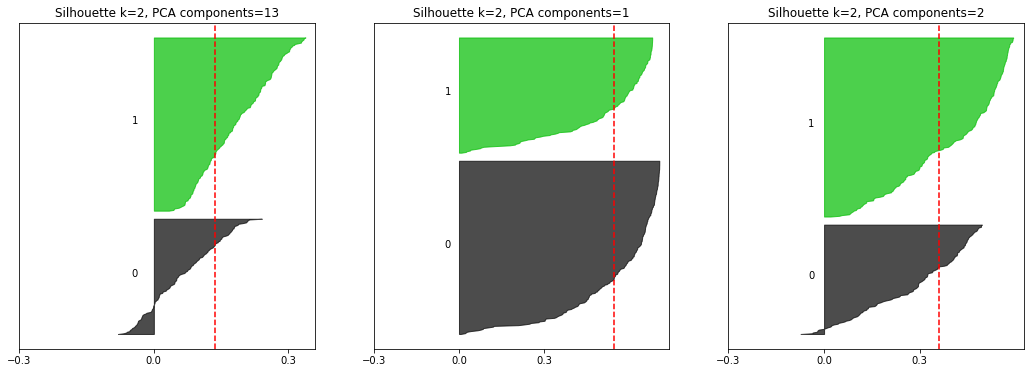

In [26]:

msds_utils.silhouette_graphs([{
    'k': BEST_K,
    'silhouette_mean': best_kmeans_silhouette_score,
    'predictions': best_kmeans_predictions,
    'silhouette_values': sklearn.metrics.silhouette_samples(best_pca_X, best_kmeans_predictions)
}, {
    'k': BEST_K,
    'silhouette_mean': comparison1_kmeans_silhouette_score,
    'predictions': comparison1_kmeans_predictions,
    'silhouette_values': sklearn.metrics.silhouette_samples(comparison1_pca_X, comparison1_kmeans_predictions)
}, {
    'k': BEST_K,
    'silhouette_mean': comparison2_kmeans_silhouette_score,
    'predictions': comparison2_kmeans_predictions,
    'silhouette_values': sklearn.metrics.silhouette_samples(comparison2_pca_X, comparison2_kmeans_predictions)
}], figure_cols=3, size=6.0, titles=[
    f'Silhouette k={BEST_K}, PCA components={BEST_PC}',
    f'Silhouette k={BEST_K}, PCA components=1',
    f'Silhouette k={BEST_K}, PCA components=2'
])


## 5.E Conclusion

The middle silhouette plot (`k=2`, `PC=1`) has **NO** incorrect cluster assignments, at least according to silhouette score!

# References

* Dmitry (2019, February).  Principal component analysis and k-means clustering to visualize a high dimensional dataset.  Retrieved from https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

* Scikit-Learn.Org (n.d.). sklearn.metrics.silhouette_score.  Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

 
